In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759583 sha256=d06be64eccf31d5ac83d39d6ee6ef4c7790d3a6c6e715cd593e033cc402f15ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-jx99uipl/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
     

In [3]:
!pip install netcdf4
!pip install pyMCR
!pip install geopandas

     |████████████████████████████████| 4.7MB 4.4MB/s 
     |████████████████████████████████| 317kB 36.8MB/s 
     |████████████████████████████████| 921kB 5.1MB/s 
  Created wheel for pyMCR: filename=pyMCR-0.3.2-cp37-none-any.whl size=26472 sha256=3a663de2780397919ff9139d3fdb422a6098a45b2573d8e592ba263daaa79063
  Stored in directory: /root/.cache/pip/wheels/bf/61/c2/59ca0fb0ad90a9f608586e960a20e03449982e39d88ab2be2f
Successfully built pyMCR
     |████████████████████████████████| 1.0MB 5.3MB/s 
     |████████████████████████████████| 15.3MB 318kB/s 


# Libraries

In [4]:
#!/bin/env python
import sys
import glob
import os
import numpy as np
import numpy.ma as ma
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
import torch
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage import measure, transform
from scipy.ndimage import label
from scipy.spatial import distance
from scipy import ndimage
from shapely.geometry import Point, LineString, Polygon, LinearRing, MultiPoint
from descartes import PolygonPatch
import networkx as nx
import tarfile
import string
import calendar
import cv2
from google.colab.patches import cv2_imshow
from mpl_toolkits.basemap import Basemap,cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4
from geopandas import GeoSeries
from skimage import io
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import seaborn as sns


In [5]:
DIR = '/content/drive/MyDrive/StageUParis/DATA/H2O/'
DIR_TEST = '/content/drive/MyDrive/StageUParis/Test/'

# Class **SplitImageLevels**

In [112]:
class SplitImageLevels():
  DIR = ""
  
  image_type = "LT"
  year = 2008
  month = 5
  day = 1

  degree = 0.625
  pixel_size = 0.3125
  vmax = 35
  vmin = 0

  images = list()

  def __init__ (self,DIR):
    self.DIR = DIR

  def set_year(self,year):
    self.year = year
  
  def set_month(self,month):
    self.month = month

  def set_day(self,day):
    self.day = day

  def set_image_type(self,image_type):
    self.image_type = image_type

  def set_image_name(self,image_name):
    self.image_name = image_name

  def set_pixel_size(self, degree, size):
    self.degree = degree
    self.pixel_size = size

  def set_region_area(self, max_area, min_area):
    self.max_area = max_area
    self.min_area = min_area

  def set_weight_gray_values(self, weight_gray_values):
    self.weight_gray_values = weight_gray_values

  def get_image_by_leves (self):
    #for index, layer in enumerate(np.arange(self.start, self.end, self.steps)):
    index = 0
    
    lat_g = np.arange(20.,50.,self.degree)
    lon_g = np.arange(100.,150.,self.degree)

    #initialization
    self.colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

    for year in range(self.year, self.year + 1):
      for month in range(self.month, self.month + 1):
        for day in range(self.day, self.day + 1):

          fname = self.DIR + 'IASIdaily_' + str(year) + '%02d'%month+'%02d'%day+'.nc'
          self.image_name = self.image_type + '-level-' + str(year) + '%02d'%month+'%02d'%day+'.png'

          print('reading info ...')

          if not(os.path.isfile(fname)):
            continue

          nc = netCDF4.Dataset(fname)
          flag = nc.variables['flag'][:]
          mask1 = (flag == 0) # Without clouds
          
          lat = nc.variables['lat'][mask1]
          lon = nc.variables['lon'][mask1]
          col = nc.variables[self.image_type][mask1]
          nc.close()

          mask2 = (np.isnan(col) == False) 

          # gridding the data
          for ilat in range(lat_g.shape[0]):
            for ilon in range(lon_g.shape[0]):
              # Grille régulier
              # 25 km
              # 0 25 degrée lattitude et longitude

              # Grille regulier of 0.125 degree
              maskgrid = (lat[:] >= (lat_g[ilat] - self.pixel_size)) & (lat[:] < (lat_g[ilat] + self.pixel_size)) & (lon[:] >= (lon_g[ilon] - self.pixel_size)) & (lon[:] < (lon_g[ilon] + self.pixel_size))
              
              # Defining invalid data
              mask = mask2 & maskgrid

              if len(col[mask]) != 0:
                median = np.mean(col[mask])
                #if median >= layer:
                self.colgrid[ilat,ilon] = median

          print('data readed correctly')

          # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
          self.colgrid1 = ma.masked_values(self.colgrid, 0.)

          self.v_x, self.v_y = np.meshgrid(lon_g, lat_g)
          gradx, grady = np.gradient(self.colgrid, edge_order=1)

          fig, (ax1) = plt.subplots(1, 1, figsize = (11,8))
          ax1.pcolormesh(self.v_x, self.v_y, self.colgrid, shading='nearest',cmap='gray', vmin=self.vmin, vmax=self.vmax)
          ax1.axis('off')
          fig.savefig(self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig)





  ###############################################################
  ###             LOAD INFO
  ###############################################################

  def load_image_from_files (self):
    img_bgr = io.imread(self.image_name) 
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    return img_bgr, gray    


  def process_set_images(self, image):
    image, _, background = self.filter_image(image)
    regions, _ = self.get_mser_regions(image)
    
    regx, regy, poly, line, values = self.set_mser_regions(image, background, regions[:])
    labels, centers = self.classify_neighbors(image, regx, regy ,poly, values)
    self.plot_mser_final_regions(image, regx, regy, values)
    
    #self.show_mser_red_regions(image, regions[:], labels)
    #polys = self.classify_regions(image,poly[:])
    #polys = self.classify_all_regions(image, poly[:])
    #self.plot_mser_regions_3d(regx, regy, values, labels)
    







  ###############################################################
  ###             TRAITEMENT
  ###############################################################

  def resize_image_percentage (self, image, scale_percent = 100):
    ### SCALE
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    return image

  def normalize_image(self, image):
    return cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , 0, 255, cv2.NORM_MINMAX )

  def pretraitement_image(self, image, kernel_size = 9, iterations=3):
    ### MORPHO FILTERS
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations = iterations)

    return image

  ## REMOVING THE HOLES
  def masking_interest_region(self, image):
    # Take the holes (pixels value = 0) and set it as 255
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )
    image = np.where(image == 0, 255, image) 
    image = np.where(image != 255, 0, image) # This is the mask of the background
    image_holes_dilate = cv2.morphologyEx(image, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 3)
    image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate) # This is the mask of the foreground

    return image_holes_dilate, image_holes_dilate_inv

  def find_edges (self, image):
    ## Below code convert image gradient in both x and y direction
    image = cv2.Laplacian(image, cv2.CV_64F, ksize=3) 
    image = np.uint8(np.absolute(image))
    #image_laplacian = cv2.bitwise_and(image_laplacian,image_laplacian,mask = image_holes_dilate_inv)

    return image


  def filter_image (self, image):
    image = self.resize_image_percentage(image, 100)
    image = self.pretraitement_image(image,6,3)
    background, foreground = self.masking_interest_region(image)
    
    return image, foreground, background

  def get_mser_regions(self, image):
    mser = cv2.MSER_create(5, 300, 50000, .25, 1., 1000, 1.01, 0.003, 5)
   
    fig, ax = plt.subplots(1,1)
    colorinfo = ax.imshow(image, cmap='gray')
    fig.colorbar(colorinfo)

    regions, bboxes = mser.detectRegions(image)
    regions = sorted(regions, key=cv2.contourArea, reverse=True)

    return regions, bboxes







  ###############################################################
  ###             PLOTTING
  ###############################################################

  def show_mser_red_regions(self, image, regions, labels):
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    #colors = np.array([(255,0,0),[(0,255,0),(0,0,255),(0,255,255),(255,255,0),(100,0,100),(24,180,0)])
    colors = list([(255,0,0),(0,255,0),(0,0,255),(0,255,255),(255,255,0),(100,0,100),(24,180,0)])

    #for i in labels:
    #  print(colors[i])

    #for l in labels:
    for i, p in enumerate(regions[:]):
      if i == (len(regions[:3]) - 1):
        color = (255,0,0)
      elif i == (len(regions[:3]) - 2):
        color = (0,0,255)
      else:
        color = (0,255,0)

      #print("color", color, "for", i)
      for k in p:
        cv2.circle(image, (k[0],k[1]), radius=0, color=color, thickness=-1)

    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    #ax.invert_yaxis()












  def set_mser_regions(self, image, background, regions):
    regsX = list()
    regsY = list()
    regsPoly = list()
    regsLine = list()
    values_gray = list()

    for j,r in enumerate(regions):
      region = list()
      hull = cv2.convexHull(r)

      for h in hull:
          region.append(h[0].tolist())

      region.append(region[0])
      poly = Polygon(region)
      line = LineString(region)
      value_pixel = self.get_region_value(image,poly)

      xs = [pnt[0] if background[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
      ys = [pnt[1] if background[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
      #xs = [pnt[0] for pnt in r]
      #ys = [pnt[1] for pnt in r]

      regsX.append(xs)
      regsY.append(ys)
      regsPoly.append(poly)
      regsLine.append(line)
      values_gray.append(value_pixel)

    return regsX, regsY, regsPoly, regsLine, values_gray

  def classify_neighbors(self, image, regsX, regsY, polygons, values):
    #ca = np.zeros([len(polygons),len(polygons), len(values)], np.uint16)
    coordinatesList = list()

    # Ploting weights
    w_coords_x = list()
    w_coords_y = list()
    w_grays = list()

    for i,value in enumerate(values):
      #if value is None or value is np.nan:
      #  continue

      coord_x = int(polygons[i].centroid.x)
      coord_y = int(polygons[i].centroid.y)
      value = int(values[i] * self.weight_gray_values)

      ## To apply kmeans
      coordinatesList.append(np.array([coord_x,coord_y, value]))
      
    coordinatesArray = np.asarray(coordinatesList)

    # NORMALIZATION ARRAY
    coordinatesNorm = (coordinatesArray - coordinatesArray.min()) / (coordinatesArray.max() - coordinatesArray.min())


    ## To plot weights
    for coord in coordinatesNorm:
      w_coords_x.append(coord[0])
      w_coords_y.append(coord[1])
      w_grays.append(coord[2])

    a = 2
    b = 1

    fig_, ax0 = plt.subplots(1,1)
    number_regions = np.arange(len(coordinatesNorm))

    w_legends = ["X","Y","Gray"]
    ax0.plot(number_regions, w_coords_x, label=w_legends[0])
    ax0.plot(number_regions, w_coords_y, label=w_legends[1])
    ax0.plot(number_regions, w_grays, label=w_legends[2])
    ax0.set_title("Weights comparison")
    ax0.set_xlabel("Number of Regions")
    ax0.set_ylabel("Weight")
    hand, labl = ax0.get_legend_handles_labels()
    plt.legend()




    #if a > b:
    #  return a, b


    # TESTING KMEANS
    wcss = list()
    for i in range(1,50):
      kmeanstest = KMeans(n_clusters=i, random_state=0).fit(coordinatesNorm)
      wcss.append(kmeanstest.inertia_)
      
    fig0, ax = plt.subplots(1,1)
    ax.plot( np.arange(len(wcss)) , wcss)
    ax.set_title("Optimal number of clusters")
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Inertia")

    clustering = KMeans(n_clusters=15, max_iter=300).fit(coordinatesNorm)
 
    x_range = [100, 150, 10]
    y_range = [20, 48, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / 28)) + 20)
      rgsY2.append(line)

    fig, ax1 = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)
    
    #print("values", values)
    #print("labels", clustering.labels_)
    #print("center", clustering.cluster_centers_)

    colors = sns.color_palette("hls", max(clustering.labels_) + 1)

    #legends = []
    #for i in range(max(clustering.labels_)):
    #    legends.append('c-{}'.format(i))

    #legends = ['c1','c2','c3']

    for i,label in enumerate(clustering.labels_):
      ax1.scatter(rgsX2[i],rgsY2[i], marker='.',c=np.array(colors[label]).reshape(1,-1) ) 
      ax1.set_xlim(*x_range)
      ax1.set_ylim(*y_range)
      ax1.set_title('IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year) + " - Weights: " + str(self.weight_gray_values))
    
    #hand, labl = ax1.get_legend_handles_labels()
    #plt.legend(np.unique(labl))
    
    return clustering.labels_ , clustering.cluster_centers_








    
  def classify_regions(self, image, polygons):
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )

    temp_polygons = polygons.copy()
    first_poly = temp_polygons[0]

    for i,poly in enumerate(temp_polygons[:]): 
      if poly is None:
        continue 

      #for j,ut in enumerate(ut_polys[:]):
      if first_poly.intersects(poly):
        percentage = (first_poly.intersection(poly).area/first_poly.area) * 100

        if percentage > 85:
          value_poly_1 =  self.get_region_value(image, first_poly)
          value_poly_n =  self.get_region_value(image, poly)
          if np.abs(value_poly_1 - value_poly_n) < 5:
            temp_polygons[i] = None

    return temp_polygons



  def classify_all_regions(self, image, polygons):
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )
    
    temp_polygons = polygons.copy()
    #first_poly = temp_polygons[0]

    for i, poly in enumerate(temp_polygons[:]): 
      if poly is None:
        continue 
      
      if i == 0:
        first_poly = temp_polygons[0]
      #else:
      #  first_poly = poly

      if first_poly.intersects(poly):
        percentage = (first_poly.intersection(poly).area / first_poly.area) * 100

        if percentage > 85:
          value_poly_1 =  self.get_region_value(image, first_poly)
          value_poly_n =  self.get_region_value(image, poly)

          if np.abs(value_poly_1 - value_poly_n) < 5:
            temp_polygons[i] = None

    return temp_polygons


  def get_region_value(self, image, polygon):
    """
    This function returns the mean pixel value from a given polygon
    """
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )

    minx, miny, maxx, maxy = polygon.bounds #Boite englobante

    pixel_steps_x = image.shape[1] * self.degree / self.colgrid.shape[1]
    pixel_steps_y = image.shape[0] * self.degree / self.colgrid.shape[0]
    
    longs = np.arange(minx, maxx, int(pixel_steps_x))
    lats = np.arange(miny, maxy, int(pixel_steps_y))

    set_of_coordinates = list()
    for lon in longs:
      for lat in lats:
        set_of_coordinates.append(image[int(lat), int(lon)])

    value_pixel = np.mean(set_of_coordinates)
    
    return value_pixel


  def plot_mser_final_regions (self, image, regsX, regsY, values):

    x_range = [100, 150, 10]
    y_range = [20, 48, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / 28)) + 20)
      rgsY2.append(line)

    fig, ax = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)
    
    colors = sns.color_palette("YlOrBr", int(max(values)) + 1)

    for i,val in enumerate(values):
      ax.scatter(rgsX2[i],rgsY2[i],marker='.',c=np.array(colors[int(val)]).reshape(1,-1))
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.set_title('IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))




  def plot_mser_regions_3d(self, regsX, regsY, values, labels):
    
    f3d = plt.figure(figsize=(14, 9))
    ax2 = plt.axes(projection ='3d')

    #colors = np.array(["yellow","blue","red","green","magenta","cyan","gray"])
    #colors = {0:"yellow", 1:"blue", 2:"red", 3: "green", 4: "magenta", 5: "cyan", 6:"gray"}
    #print("values", values)
    #print("labels", clustering.labels_)
    #print("center", clustering.cluster_centers_)
    
    for i,label in enumerate(labels):

      if label == 0:
        color = "red"
      elif label == 1:
        color = "yellow"
      elif label == 2:
        color = "green"
      elif label == 3:
        color = "magenta"
      elif label == 4:
        color = "cyan"
      elif label == 5:
        color = "gray"
      elif label == 6:
        color = "olive"
      else:
        color = "black"

      ax2.scatter(regsX[i], regsY[i], values[i], marker='.', c=color) # c=colors[clustering.labels_]       #,label='Region ' + str(i))
      ax2.set_title('IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))
      



  def show_image(self, image):
    fig, ax = plt.subplots(1,1, figsize=(11,8))
    ax.imshow(image, cmap='gray')

  def plot_original_image(self, vmin, vmax):
    fig, (ax1) = plt.subplots(1,1)
    cs = ax1.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=vmin, vmax=vmax)
    ax1.set_title('IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))
    fig.colorbar(cs)

    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)


  ###############################################################
  ###             REMOVE TEMP FILES
  ###############################################################

  def remove_temporal_files(self):
    try:
      os.remove(self.image_name)
      #Raising your own errors
      raise ErrorType("Deleting")
    except ErrorType as e:
      print("Error deleting the file -> ", self.image_name)
    


  

In [113]:
imageLT = SplitImageLevels(DIR)

In [114]:
imageLT.set_year(2008)
imageLT.set_month(5)
imageLT.set_day(6)
imageLT.set_image_type("LT")
imageLT.set_image_name("levels")
imageLT.set_weight_gray_values(40)

In [115]:
imageLT.get_image_by_leves()

reading info ...
data readed correctly


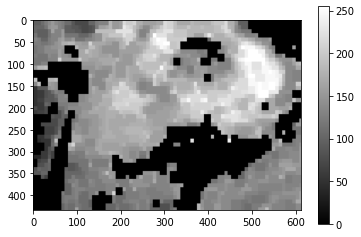

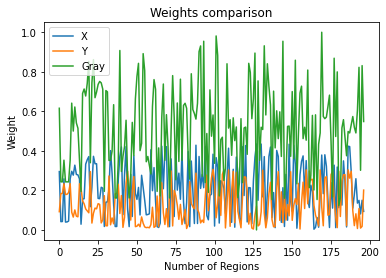

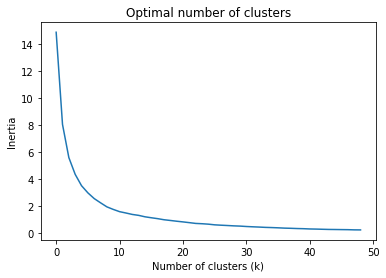

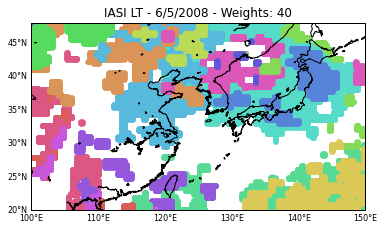

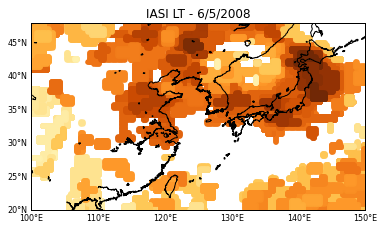

In [116]:
_, gray = imageLT.load_image_from_files()
imageLT.process_set_images(gray)
#imageLT.remove_temporal_files()
#imageLT.plot_original_image(7,35)

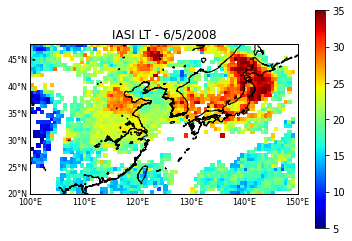

In [118]:
if imageLT.image_type == 'LT':
  vmax = 35
else:
  vmax = 45
imageLT.plot_original_image(5,vmax)